The todos here as follows 


## A

1) examine whether the OV output of (2, 17) is aligned with the steering vector 

it kind of isnt 

2) examine whether patching head (2, 17) causes changes further in the network which mirror those of the steering vector -- especially when more activated 

it seems that it does

---------------------------

## B

1) examine the source of (2, 17) 
 - is it the head that was noted to be activated by think and /think

try the combination of those two heads 

2) can we show this?


----------------------------
## C

1) turning on and off the steering vector 
 - go layer by layer to see where the effect is greatest? 
 - use your metric to do this

-----------------------------
## D

1) Quantify the influence of the steering vector 
 - on thikning prompts 
 - on answering prompts

----------------------------
## E 

1) examine the cosine similarity between the unembeds and the final weight vector 

still no similarity to any word

In [1]:
from activation_patching_toolkit import *
from typing import Union

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [3]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')
steering_vectors = [None]+[-torch.tensor(w[None, :], device='cuda:0') for w in weight_vectors]

In [4]:
rc = ReasoningAnsweringComparator(
    model,
    "What is the fifth prime?",
    immediately_answer=True,
)

rc.think_prefix

'<｜begin▁of▁sentence｜><｜User｜>What is the fifth prime?<｜Assistant｜><think>\n'

In [5]:
model.generate(
    rc.think_prefix,
    max_new_tokens=100,
    do_sample=False,
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 13.59it/s]


"<｜User｜>What is the fifth prime?<｜Assistant｜><think>\nTo determine the fifth prime number, I'll start by listing the prime numbers in order.\n\nFirst, I know that 2 is the smallest and only even prime number.\n\nNext, 3 is the second prime number.\n\nThen, 5 comes after 3 as the third prime.\n\nFollowing that, 7 is the fourth prime number.\n\nFinally, 11 is the fifth prime number.\n</think>\n\nTo find the **fifth prime number**, let's list the prime numbers in order until we reach"

In [6]:
def interpolate_and_patch_head(
    model: HookedTransformer,
    think_prompt: str,
    answer_prompt: str,
    layer_idxs: Union[int, List[int]],
    head_idxs: Union[int, List[int]],
    slider: float = 1.0,
    scale: float = 1.0,
    device: str = None
) -> Tuple[torch.Tensor, Dict[int, torch.Tensor], Dict[Tuple[int,int], torch.Tensor], Dict[Tuple[int,int], torch.Tensor]]:
    """
    1) For each (layer, head) pair, extract head-output z at final position for both prompts.
    2) Interpolate z_used = (1-slider)*z_think + slider*z_ans, then scale.
    3) Patch each z_used into its corresponding head at the final token when running think_prompt.
    4) Capture each layer’s resid_pre into all_residuals.

    Returns:
      logits_final:    [vocab_size] logits at the last token of think_prompt
      all_residuals:   {layer: resid_pre_tensor} with resid_pre_tensor shape [1, seq_len, d_model]
      z_used_map:      {(L,H): [head_dim]} the interpolated & scaled head outputs
      residual_proj:   {(L,H): [d_model]} = z_used @ W_O[L][H]
    """
    # standardize inputs
    if isinstance(layer_idxs, int): layer_list = [layer_idxs]
    else: layer_list = layer_idxs
    if isinstance(head_idxs, int): head_list = [head_idxs]
    else: head_list = head_idxs
    assert len(layer_list) == len(head_list), "layer_idxs and head_idxs must match in length"

    # prepare model/device
    if device:
        model = model.to(device)
    else:
        device = next(model.parameters()).device

    # tokenize
    toks_think = model.to_tokens(think_prompt).to(device)
    toks_ans   = model.to_tokens(answer_prompt).to(device)
    pos_think  = toks_think.shape[1] - 1
    pos_ans    = toks_ans.shape[1] - 1

    # helper to grab z map for specified layers
    def grab_z_map(prompt_toks: torch.Tensor) -> Dict[int, torch.Tensor]:
        z_map: Dict[int, torch.Tensor] = {}
        hooks = []
        for L in set(layer_list):
            def make_hook(lidx: int):
                def _hook(act, hook):
                    z_map[lidx] = act.detach().cpu()
                return _hook
            hooks.append((f"blocks.{L}.attn.hook_z", make_hook(L)))
        model.run_with_hooks(prompt_toks, fwd_hooks=hooks, return_type=None)
        return z_map

    # 1) Grab z_think_map and z_ans_map per layer
    z_think_map = grab_z_map(toks_think)
    z_ans_map   = grab_z_map(toks_ans)

    # 2) interpolate + scale per head
    z_used_map: Dict[Tuple[int,int], torch.Tensor] = {}
    for L, H in zip(layer_list, head_list):
        z0 = z_think_map[L][0, pos_think, H]
        z1 = z_ans_map[L][0, pos_ans,   H]
        z_used_map[(L,H)] = ((1 - slider)*z0 + slider*z1) * scale

    # 3) build hooks: patches for each head, capture resid_pre per layer
    all_residuals: Dict[int, torch.Tensor] = {}
    fwd_hooks = []

    # patch hooks
    for (L,H), z_vec in z_used_map.items():
        def make_patch(lidx: int, hidx: int, zvec: torch.Tensor):
            def _patch(act, hook):
                p = act.clone()
                p[0, pos_think, hidx, :] = zvec.to(act.device)
                return p
            return _patch
        fwd_hooks.append((f"blocks.{L}.attn.hook_z", make_patch(L, H, z_vec)))

    # capture resid_pre hooks
    def make_capture_resid(lidx: int):
        def _cap(act, hook):
            all_residuals[lidx] = act.detach().cpu()[0, -1, :]
        return _cap

    n_layers = model.cfg.n_layers
    for L in range(n_layers):
        fwd_hooks.append((f"blocks.{L}.hook_resid_pre", make_capture_resid(L)))

    # 4) run patched model and get final logits
    logits = model.run_with_hooks(
        toks_think,
        fwd_hooks=fwd_hooks,
        return_type="logits"
    )  # [1, seq_len, vocab_size]
    logits_final = logits[0, pos_think]

    # compute residual projections per head
    residual_proj: Dict[Tuple[int,int], torch.Tensor] = {}
    for (L,H), z_vec in z_used_map.items():
        W_O = model.blocks[L].attn.W_O  # [n_heads, head_dim, d_model]
        W_h = W_O[H].cpu()              # [head_dim, d_model]
        residual_proj[(L,H)] = z_vec.cpu() @ W_h

    return logits_final, all_residuals, z_used_map, residual_proj

# A 1

is OV </think>\n\n for (2, 17) aligned with the steering vector ?

In [7]:
model(model.to_tokens("hey whats up"), return_type="logits")

tensor([[[ 1.1601,  2.0860,  4.8631,  ..., -1.1549, -1.1549, -1.1549],
         [11.3402,  3.3309,  1.8816,  ..., -4.4785, -4.4787, -4.4787],
         [ 4.6840,  2.2228, -0.2896,  ..., -4.4618, -4.4620, -4.4618],
         [ 9.8656,  4.4011,  2.3885,  ..., -4.6078, -4.6082, -4.6081]]],
       device='cuda:0')

In [8]:
rc.think_prefix

'<｜begin▁of▁sentence｜><｜User｜>What is the fifth prime?<｜Assistant｜><think>\n'

In [9]:
logits_final, all_z_residual_contributions, z_used, residual_proj = interpolate_and_patch_head(
    model,
    think_prompt=rc.think_prefix,
    answer_prompt=rc.answer_prefix,
    layer_idxs=2,
    head_idxs=17,
    slider= 1.0,
    scale= 1.0,
)

In [10]:
residual_proj

{(2, 17): tensor([ 0.0715, -0.0187,  0.0268,  ...,  0.0229,  0.0489,  0.0120])}

In [11]:
# define cosine similarity function

def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two vectors.
    """
    a = a.flatten()
    b = b.flatten()
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


cosine_similarity(steering_vectors[3].cpu().numpy(), residual_proj[(2, 17)].cpu().numpy())

np.float32(0.0042588166)

In [12]:
from scipy.special import erf
import math

d = 4096
threshold = 0.004
sigma = 1 / math.sqrt(d)

# Compute one-sided tail probability: P(X > threshold) for X ~ N(0, 1/d)
p = 0.5 * (1 - erf(threshold / (sigma * math.sqrt(2))))

print(f"Probability that dot > {threshold} in dim {d} ≈ {p:.6f}")


Probability that dot > 0.004 in dim 4096 ≈ 0.398975


Let's sweep along the direction of think to answer and see if the residual stream shows the pattern 

In [13]:


def compute_layerwise_resid_diff(
    model: HookedTransformer,
    think_prompt: str,
    answer_prompt: str,
    layer_idxs: Union[int, List[int]],
    head_idxs: Union[int, List[int]],
    device: str = None,
    think_scale: float = 1.0,
    ans_scale: float = 1.0,
) -> Dict[int, torch.Tensor]:
    """
    For slider=0 (think) and slider=1 (answer) at the specified heads,
    run `interpolate_and_patch_head` twice, capture each layer’s resid_pre
    at the final token, and return the per-layer difference:

      resid_diff[L] = resid_ans[L] - resid_think[L]

    Args:
      model            : a HookedTransformer
      think_prompt     : the “think” prompt string
      answer_prompt    : the “answer” prompt string
      layer_idxs       : int or list of layer indices to patch
      head_idxs        : int or list of head indices (same length as layer_idxs)
      device           : optional device string

    Returns:
      layer_diffs      : mapping layer_index → Tensor[d_model]
    """
    # ensure lists
    if isinstance(layer_idxs, int):
        layer_list = [layer_idxs]
    else:
        layer_list = layer_idxs
    if isinstance(head_idxs, int):
        head_list = [head_idxs]
    else:
        head_list = head_idxs
    assert len(layer_list) == len(head_list), "layer_idxs and head_idxs must be same length"

    # slider = 0 → no patch
    _, resid_think, _, _ = interpolate_and_patch_head(
        model, think_prompt, answer_prompt,
        layer_list, head_list,
        slider=0.0, scale=think_scale,
        device=device
    )
    # slider = 1 → full patch
    _, resid_ans, _, _ = interpolate_and_patch_head(
        model, think_prompt, answer_prompt,
        layer_list, head_list,
        slider=1.0, scale=ans_scale,
        device=device
    )

    # compute difference per layer
    layer_diffs: Dict[int, torch.Tensor] = {}
    for L, r0 in resid_think.items():
        r1 = resid_ans[L]
        layer_diffs[L] = r1 - r0

    return layer_diffs

In [14]:
layer_diffs = compute_layerwise_resid_diff(
    model=model,
    think_prompt= rc.think_prefix,
    answer_prompt= rc.answer_prefix,
    layer_idxs=2,
    head_idxs=17,
)

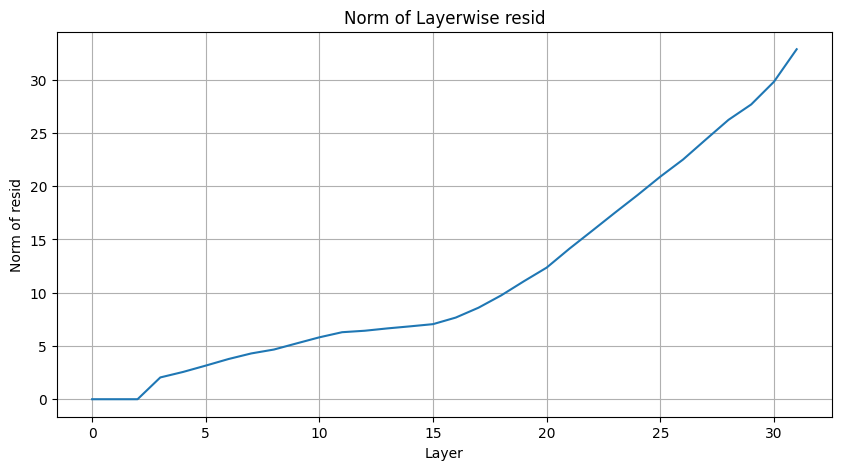

In [15]:
# plot norms of layer_diffs
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(list(layer_diffs.keys()), [torch.norm(v).item() for v in layer_diffs.values()])
ax.set_xlabel("Layer")
ax.set_ylabel("Norm of resid")
ax.set_title("Norm of Layerwise resid")
ax.grid()
plt.show()


In [16]:
layer_diffs

{0: tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 1: tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 2: tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 3: tensor([ 0.0781, -0.0176,  0.0375,  ...,  0.0036,  0.0458,  0.0508]),
 4: tensor([ 0.0585, -0.0014,  0.0445,  ...,  0.0359,  0.0701,  0.0649]),
 5: tensor([ 0.1831, -0.0084,  0.0277,  ...,  0.0278,  0.1012,  0.0658]),
 6: tensor([ 0.2016,  0.0454, -0.0286,  ..., -0.0342,  0.1050,  0.0518]),
 7: tensor([ 0.2048,  0.0835, -0.1044,  ...,  0.0194,  0.0881,  0.0005]),
 8: tensor([ 0.1261,  0.0864, -0.0476,  ...,  0.0143,  0.0437, -0.0061]),
 9: tensor([ 0.0862,  0.0944,  0.0291,  ..., -0.0327, -0.0163, -0.0296]),
 10: tensor([-0.1042,  0.0591,  0.0096,  ..., -0.0385,  0.0454, -0.0515]),
 11: tensor([-0.0502,  0.0383, -0.0907,  ..., -0.0530,  0.0175, -0.1014]),
 12: tensor([-0.0751,  0.0188, -0.1045,  ..., -0.0675,  0.0096, -0.1377]),
 13: tensor([-0.0504, -0.0082, -0.1191,  ..., -0.0305, -0.0054, -0.0847]),
 14: tensor([-0.1014,  0.1151, -0.1471,  ..., -0.0

/tmp/ipykernel_2613/171396140.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


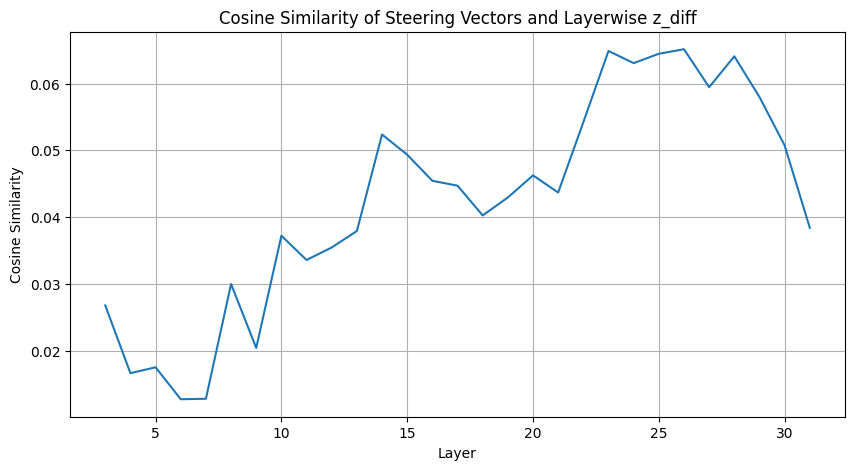

In [17]:
steering_layers, steering_similarities = zip(*[(L, cosine_similarity(v[0].cpu().numpy(), layer_diffs[L].cpu().numpy())) for L, v in enumerate(steering_vectors) if v is not None])
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(steering_layers, steering_similarities)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity of Steering Vectors and Layerwise z_diff")
ax.grid()
plt.show()
# save steering_similarities to file

In [18]:
layer_diffs = compute_layerwise_resid_diff(
    model=model,
    think_prompt= rc.think_prefix,
    answer_prompt= rc.answer_prefix,
    layer_idxs=[0,2,],# 9, 10],
    head_idxs=[19,17,]# 5, 4],
)

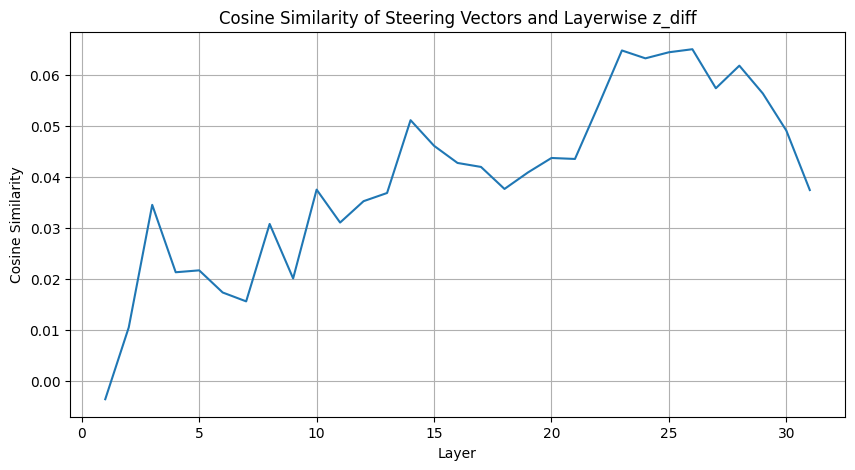

In [19]:
steering_layers, steering_similarities = zip(*[(L, cosine_similarity(v[0].cpu().numpy(), layer_diffs[L].cpu().numpy())) for L, v in enumerate(steering_vectors) if v is not None])
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(steering_layers, steering_similarities)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity of Steering Vectors and Layerwise z_diff")
ax.grid()
plt.show()

In [20]:
layer_diffs = compute_layerwise_resid_diff(
    model=model,
    think_prompt= rc.think_prefix,
    answer_prompt= rc.answer_prefix,
    layer_idxs=[0,2, 9, 10],
    head_idxs=[19,17, 5, 4],
)

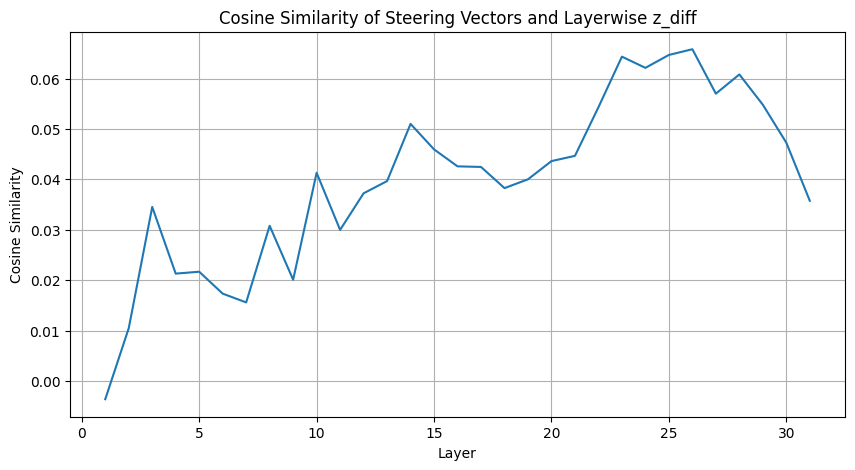

In [21]:
steering_layers, steering_similarities = zip(*[(L, cosine_similarity(v[0].cpu().numpy(), layer_diffs[L].cpu().numpy())) for L, v in enumerate(steering_vectors) if v is not None])
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(steering_layers, steering_similarities)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity of Steering Vectors and Layerwise z_diff")
ax.grid()
plt.show()

## Now lets try scaling up the contribution of the answer patch

In [22]:
layer_diffs_scaled = compute_layerwise_resid_diff(
    model=model,
    think_prompt= rc.think_prefix,
    answer_prompt= rc.answer_prefix,
    layer_idxs=[0,2],
    head_idxs=[19,17],
    ans_scale=2,
)

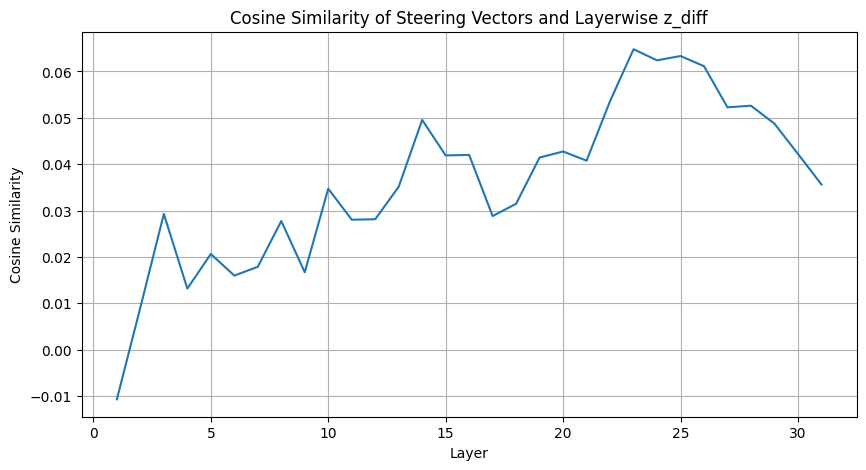

In [24]:
steering_layers, steering_similarities = zip(*[(L, cosine_similarity(v[0].cpu().numpy(), layer_diffs_scaled[L].cpu().numpy())) for L, v in enumerate(steering_vectors) if v is not None])
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(steering_layers, steering_similarities)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity of Steering Vectors and Layerwise z_diff")
ax.grid()
plt.show()

In [23]:
kjh

NameError: name 'kjh' is not defined

Let's use LDA

In [ ]:

def compute_lda_residual_directions(
    model: HookedTransformer,
    think_prompts: List[str],
    answer_prompts: List[str],
    layer_idx: int,
    head_idx: int,
    device: str = None,
    reg: float = 1e-6
) -> Tuple[Dict[int, torch.Tensor], Dict[int, torch.Tensor]]:
    """
    For each layer L, collects the final-token resid_pre vectors under:
      • slider=0 (think mode)
      • slider=1 (answer mode)
    across a corpus of prompt pairs, then
      1) Computes the mean-difference mu_ans - mu_think at each layer.
      2) Runs LDA to get the optimal direction w_L ∝ Sw^{-1} (mu_ans - mu_think),
         normalizes w_L to unit length.

    Returns:
      directions: {layer: unit-vector Tensor[d_model]}
      mean_diffs: {layer: (mu_ans - mu_think) Tensor[d_model]}
    """
    # make sure model is on the correct device
    if device:
        model = model.to(device)
    else:
        device = next(model.parameters()).device

    # Prepare storage for each layer
    n_layers = model.cfg.n_layers
    think_samples: Dict[int, List[torch.Tensor]] = {L: [] for L in range(n_layers)}
    ans_samples:   Dict[int, List[torch.Tensor]] = {L: [] for L in range(n_layers)}

    # Collect resid_pre for each prompt pair
    for think, ans in zip(think_prompts, answer_prompts):
        # get all_resid for slider=0 and slider=1
        _, resid_think, _, _ = interpolate_and_patch_head(
            model, think, ans, layer_idx, head_idx,
            slider=0.0, scale=1.0, device=device
        )
        _, resid_ans, _, _ = interpolate_and_patch_head(
            model, think, ans, layer_idx, head_idx,
            slider=1.0, scale=1.0, device=device
        )
        # for each layer, grab the final-token vector and store
        for L in range(n_layers):
            rt = resid_think[L]  # [1, seq, d_model]
            ra = resid_ans[L]    # [1, seq, d_model]
            vec_think = rt.to(device)  # [d_model]
            vec_ans   = ra.to(device)
            think_samples[L].append(vec_think)
            ans_samples[L].append(vec_ans)

    directions: Dict[int, torch.Tensor] = {}
    mean_diffs:  Dict[int, torch.Tensor] = {}

    # For each layer, compute LDA direction and mean-difference
    for L in range(n_layers):
        X0 = torch.stack(think_samples[L], dim=0)  # [N, d_model]
        X1 = torch.stack(ans_samples[L],   dim=0)  # [N, d_model]

        mu0 = X0.mean(dim=0)  # [d_model]
        mu1 = X1.mean(dim=0)

        mean_diff = mu1 - mu0
        mean_diffs[L] = mean_diff.detach().cpu()

        # Within-class scatter
        X0c = X0 - mu0
        X1c = X1 - mu1
        Sw = X0c.T @ X0c + X1c.T @ X1c  # [d_model, d_model]

        # Regularize and invert (pseudo-inverse if singular)
        eye = torch.eye(Sw.shape[0], device=Sw.device)
        Sw_reg = Sw + reg * eye
        w = torch.linalg.pinv(Sw_reg) @ mean_diff  # [d_model]
        w_unit = w / w.norm()
        directions[L] = w_unit.detach().cpu()

    return directions, mean_diffs

In [ ]:
prompts = read_prompts()[:50]

think_prompts, answer_prompts = [], [] 

for prompt in prompts:

    rc = ReasoningAnsweringComparator(
        model,
        prompt,
        immediately_answer=True,
    )

    think_prompts.append(rc.think_prefix)
    answer_prompts.append(rc.answer_prefix)

In [ ]:
directions, mean_diffs = compute_lda_residual_directions(
    model=model,
    think_prompts=think_prompts,
    answer_prompts=answer_prompts,
    layer_idx=2,
    head_idx=17,
    device=device
)

Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving model to device:  cuda
Moving mod

In [ ]:
lda_patched_differences = {L: directions[L]*mean_diffs[L] for L in directions}

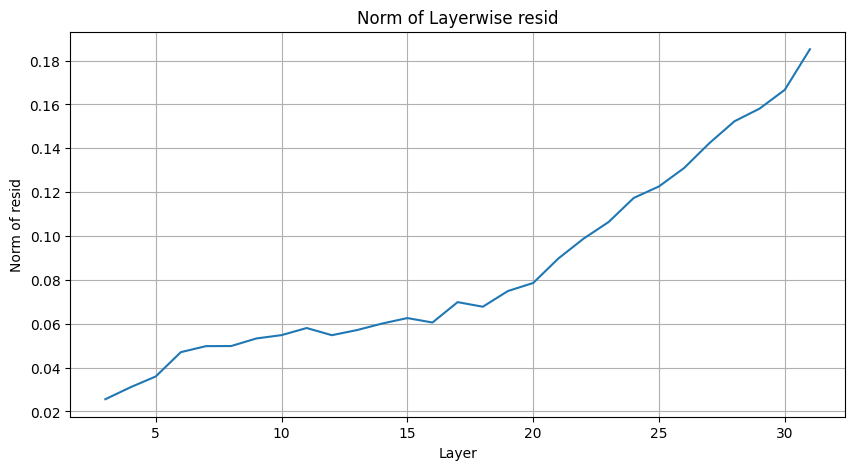

In [ ]:
# plot lda_patched_differences
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(list(lda_patched_differences.keys()), [torch.norm(v).item() for v in lda_patched_differences.values()])
ax.set_xlabel("Layer")
ax.set_ylabel("Norm of resid")
ax.set_title("Norm of Layerwise resid")
ax.grid()
plt.show()

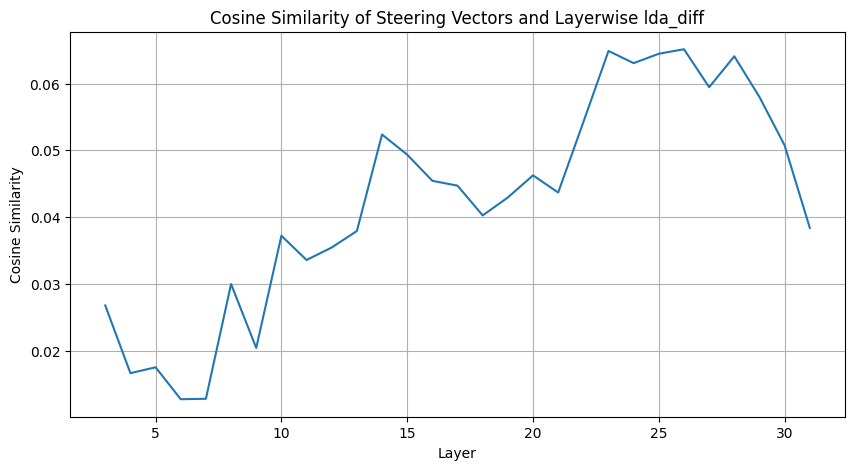

In [ ]:
steering_layers, lda_steering_similarities = zip(*[(L, cosine_similarity(v[0].cpu().numpy(), lda_patched_differences[L].cpu().numpy())) for L, v in enumerate(steering_vectors) if v is not None])
fig, ax  = plt.subplots(figsize=(10, 5))
ax.plot(steering_layers, steering_similarities)
ax.set_xlabel("Layer")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Cosine Similarity of Steering Vectors and Layerwise lda_diff")
ax.grid()
plt.show()

same answer as single prompt 

is this significant?

whats the fraction of 4096 vectors with ~ 0.05 cosine similarity 

note here if we sample two random d-dim vectors with elements from N(0, 1/d) 

then 

P(v1 . v2 > 0.05) = 1-$\Phi$(0.05 / (1/$\sqrt{4096}$)) ~ 0.000687

In [ ]:
from scipy.special import erf
import math

d = 4096
threshold = 0.05
sigma = 1 / math.sqrt(d)

# Compute one-sided tail probability: P(X > threshold) for X ~ N(0, 1/d)
p = 0.5 * (1 - erf(threshold / (sigma * math.sqrt(2))))

print(f"Probability that dot > {threshold} in dim {d} ≈ {p:.6f}")

Probability that dot > 0.05 in dim 4096 ≈ 0.000687


In [ ]:
d=4096 
s=0.05
from scipy import special
from scipy import stats

print(stats.norm.cdf(s * np.sqrt(d)))


0.9993128620620841


## E 

1) examine the cosine similarity between the unembeds and the final weight vector 

/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/mech_interp_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


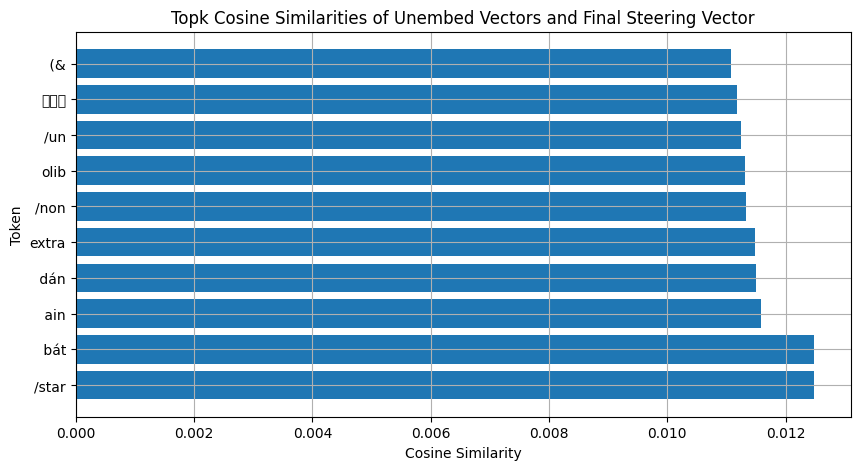

In [ ]:
unembed = model.W_U.cpu().numpy()
unembed_norms = np.linalg.norm(unembed, axis=1)
unembed /= unembed_norms[:, np.newaxis]  # Normalize each vector

final_steering = steering_vectors[-1].cpu().numpy().copy()
final_steering /= np.linalg.norm(final_steering)  # Normalize the final steering vector

cosine_sims = torch.einsum("ij, i->j", torch.tensor(unembed), torch.tensor(final_steering[0]))
topk = 10
topk_indices = torch.topk(cosine_sims, topk).indices
topk_similarities = [cosine_sims[i].item() for i in topk_indices]

# now plot these with a horizontal bar chart, printing the corresponding token 
topk_tokens = model.to_str_tokens(topk_indices)
fig, ax  = plt.subplots(figsize=(10, 5))
ax.barh(topk_tokens, topk_similarities)
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Token")
ax.set_title("Topk Cosine Similarities of Unembed Vectors and Final Steering Vector")
ax.grid()
plt.show()
# save the steering vectors to a file


['/star', ' bát', ' ain', ' dán', 'extra', '/non', 'olib', '/un', '้อง', ' (&']

In [ ]:
unembed.shape

(4096, 128256)